# Base séquentielle des parcours de soins patients

Ce notebook a pour objectif de déterminer les flux de patients, c'est-à-dire visualiser les proportions de GHM et DP selon les hospitalisations successives.

In [1]:
#Import des librairies

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import numpy as np

In [2]:
%%capture capt
p_soins=pd.read_csv("./data/parcours_soins.csv")
patients=pd.read_csv("./data/grid_search/filter_20_10_5.csv")

In [3]:
p_soins=p_soins.rename(columns={"BEN_NIR_IDT": "CODE_PATIENT"})
p_soins=p_soins.set_index("CODE_PATIENT")
patients=patients.set_index("CODE_PATIENT")

In [4]:
nb_cluster = 1
found_max = False
while not found_max:
    try:
        patients['cluster'+str(nb_cluster)]
        nb_cluster += 1
    except:
        found_max=True

nb_cluster -= 1
patients['cluster'] = [1+np.argmax(patients.loc[:, 'cluster1':'cluster'+str(nb_cluster)].iloc[i]) for i in range(len(patients))]

In [5]:
p_soins["cluster"]=patients["cluster"]

/tmp/ipykernel_774/1368965147.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  p_soins["cluster"]=patients["cluster"]


In [6]:
p_soins=p_soins.reset_index()

In [7]:
p_soins.head()

,CODE_PATIENT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,cluster
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,P13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,P16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [31]:
patients.head()

,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster1,cluster2,cluster3,cluster4,cluster5,p_soins,cluster
CODE_PATIENT,,,,,,,,,,,,,,,,,,,,
P0,2011-11-22,1949,11,1,NaN,False,2596,9,False,23,1,1,1,0,0,0,1,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2...",4
P6,2013-12-05,1929,14,2,2015-03,True,456,8,False,51,2,1,1,0,0,0,1,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0...",4
P8,2015-07-02,1967,54,2,2015-08,True,41,3,True,43,0,1,1,0,1,0,0,0,"11M041,06C194",2
P13,2011-05-19,1959,974,1,NaN,False,2783,2,False,3,0,1,0,0,1,0,0,0,"05M04T,05K051",2
P16,2010-03-18,1947,76,1,NaN,False,3210,9,False,28,1,1,1,0,0,0,1,0,"08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M1...",4


<Axes: ylabel='Density'>

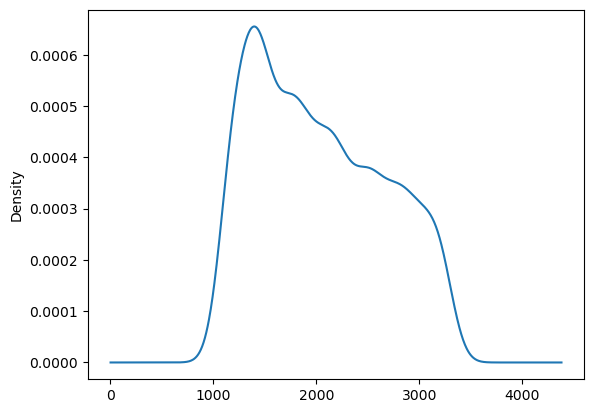

In [42]:
patients[patients['Mort']==False]['Nb_survie'].plot.kde()

<Axes: ylabel='Density'>

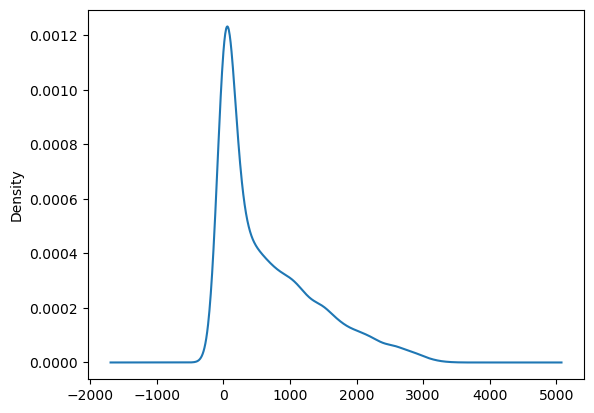

In [32]:
patients[patients['Mort']]['Nb_survie'].plot.kde()

In [ ]:
patients[patients['Mort']==False]['Nb_survie'].plot.kde()

In [40]:
patients[patients['Mort']]['Nb_survie'].quantile([.05,.50,.90])

0.05       2.0
0.50     388.5
0.90    1770.3
Name: Nb_survie, dtype: float64

## Création de la base séquentielle d'hospitalisations

In [43]:
p_soins_list=[]
for patient in tqdm(range(len(p_soins))):
    if patients.iloc[patient].Mort:
        p_soins_list.append([p_soins.iloc[patient].CODE_PATIENT]+[patients.iloc[patient].cluster]+p_soins.iloc[patient].dropna().tolist()[1:-1]+['Décès'])

100%|██████████| 10051/10051 [00:23<00:00, 431.60it/s]


Dans la base séquentielle ci-dessous, les différentes colonnes correspondent aux hospitalisations successives. Ainsi, on trouve dans la 1ère colonne le GHM de la 1ère hospitalisation, pour chacun des patients suivis.

In [44]:
p_soins_df=pd.DataFrame(p_soins_list)
p_soins_df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,P6,4,02C05J,02C05J,05M093,04M132,05C222,23M103,04M053,04M24E,...,None,None,None,None,None,None,None,None,None,None
1,P8,2,11M041,06C194,Décès,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,P17,5,24M35Z,05K062,05M131,11M042,01C061,01C061,06M12T,05K061,...,None,None,None,None,None,None,None,None,None,None
3,P19,4,08M36T,08M101,04M052,05M171,08M102,11M043,05K102,05C103,...,None,None,None,None,None,None,None,None,None,None
4,P24,1,01M201,05M13T,05K061,05M13T,05M171,05M091,05M171,05M13T,...,None,None,None,None,None,None,None,None,None,None


### Fusion des opérations de la cataracte en un seul GHM

+ [02C05J, 02C05J] --> [02C05J]
+ [02C051, 02C051] --> [02C051]

In [46]:
p_soins_new=[]
for patient in tqdm(range(len(p_soins_df))):
    p_soin = p_soins_df.iloc[patient].dropna().to_list()
    while p_soin.count('02C05J')>1:
        p_soin.remove('02C05J')
    p_soins_new.append(p_soin)

100%|██████████| 6618/6618 [00:01<00:00, 4475.14it/s]


In [47]:
p_soins_df=pd.DataFrame(p_soins_new)

In [48]:
p_soins_new=[]
for patient in tqdm(range(len(p_soins_df))):
    p_soin = p_soins_df.iloc[patient].dropna().to_list()
    while p_soin.count('02C051')>1:
        p_soin.remove('02C051')
    p_soins_new.append(p_soin)

100%|██████████| 6618/6618 [00:01<00:00, 5270.54it/s]


In [49]:
p_soins_df.to_csv("./data/p_soins_morts.csv")

### Pour les patients avec une hospitalisation pour un GHM '05M09x', en considérant cette hospitalisation comme début de parcours 

In [50]:
p_soins_df.iloc[0].dropna()

0        P6
1         4
2    02C05J
3    05M093
4    04M132
5    05C222
6    23M103
7    04M053
8    04M24E
9     Décès
Name: 0, dtype: object

In [51]:
p_soins_IC=[]
for patient in tqdm(range(len(p_soins_df))):
    parcours=p_soins_df.iloc[patient].dropna()
    #Si on trouve un GHM de type '05M09x' dans le parcours de soin du patient
    if parcours.eq('05M091').any() or parcours.eq('05M092').any() or parcours.eq('05M093').any() or parcours.eq('05M094').any() or parcours.eq('05M09T').any():
        start=0
        #On cherche la 1ère hospitalisation pour IC, pour regarder le parcours de soins à partir de celle-ci
        while parcours.tolist()[start] not in ['05M091', '05M092', '05M093', '05M094','05M09T']:
            start+=1
        p_soins_IC.append([parcours[0]]+[parcours[1]]+parcours.tolist()[start:])

100%|██████████| 6618/6618 [00:04<00:00, 1468.18it/s]


In [52]:
p_soins_IC_df=pd.DataFrame(p_soins_IC)
p_soins_IC_df.head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,P6,4,05M093,04M132,05C222,23M103,04M053,04M24E,Décès,None,...,None,None,None,None,None,None,None,None,None,None
1,P17,5,05M093,04M143,11M044,04M053,09M063,05K251,09M062,09M063,...,None,None,None,None,None,None,None,None,None,None
2,P24,1,05M091,05M171,05M13T,05M13T,05M13T,05K061,05M13T,05M13T,...,None,None,None,None,None,None,None,None,None,None
3,P30,1,05M09T,03M043,23M20Z,05M08T,05K062,19M062,23M20T,05M092,...,None,None,None,None,None,None,None,None,None,None
4,P38,4,05M092,23M15Z,23Z02Z,08M252,23Z02Z,23Z02Z,Décès,None,...,None,None,None,None,None,None,None,None,None,None


In [53]:
p_soins_IC_df.describe()

,1
count,3298.000000
mean,2.640085
std,1.202790
min,1.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,5.000000


In [54]:
p_soins_IC_df.to_csv("./data/p_soins_IC_morts.csv")